In [3]:
import pandas as pd
from homework import get_site_data

# First, lets read in and format the time series for a site
data = get_site_data()
data

                     Performance     Revenue  Customer Share  Voltus Share
2022-06-14 14:00:00      4478.76   6718.1400     4299.609600   2418.530400
2022-06-14 15:00:00      1632.96   2939.3280     1881.169920   1058.158080
2022-06-14 16:00:00      4445.28  13335.8400     8534.937600   4800.902400
2022-06-14 17:00:00      6876.36   5363.5608     3432.678912   1930.881888
                     Performance     Revenue  Customer Share  Voltus Share
2022-06-14 14:00:00      4356.00   6534.0000     4051.080000   2482.920000
2022-06-14 15:00:00      4320.36   7776.6480     4821.521760   2955.126240
2022-06-14 16:00:00      4285.80  12857.4000     7971.588000   4885.812000
2022-06-14 17:00:00      3942.36   3075.0408     1906.525296   1168.515504
                     Performance     Revenue  Customer Share  Voltus Share
2022-06-14 14:00:00      653.400   980.10000      548.856000    431.244000
2022-06-14 15:00:00      634.176  1141.51680      639.249408    502.267392
2022-06-14 16:00:00      

,kWh
Interval Beginning (EST),
2022-05-02 00:00:00,1533.6
2022-05-02 00:15:00,1490.4
2022-05-02 00:30:00,1425.6
2022-05-02 00:45:00,1414.8
2022-05-02 01:00:00,1371.6
...,...
2022-06-20 22:45:00,3294.0
2022-06-20 23:00:00,6091.2
2022-06-20 23:15:00,4730.4


The 10of10 baseline offers a unique baseline for each hour of the event (4 unique hours, 2-3, 3-4, 4-5, and 5-6 P.M). To do this, we can filter our series for the 10 preceding, non event, business days, and aggregate the mean hourly performance for each hour.

For example, the 10of10 basis for 2-3 P.M on 06/14 is the mean of the performance from 2-3 P.M on business days between 05/31 through 06/13

In [5]:
event_start = pd.Timestamp("2022-06-14 14:00:00")
event_end = pd.Timestamp("2022-06-14 14:00:00")
data[data.index.dayofweek < 5].loc[
        event_start - pd.offsets.BusinessDay(10) : event_end - pd.offsets.BusinessDay(1)
    ].index.floor("d").unique()

DatetimeIndex(['2022-05-31', '2022-06-01', '2022-06-02', '2022-06-03',
               '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09',
               '2022-06-10', '2022-06-13'],
              dtype='datetime64[ns]', name='Interval Beginning (EST)', freq=None)

In [6]:
from homework import get_10of10_baselines

#1A: Calculate the 10of10 baselines
event_start = pd.Timestamp("2022-06-14 14:00:00")
event_end = pd.Timestamp("2022-06-14 14:00:00")

def get_10of10_baselines(
    data: pd.Series = get_site_data()["kWh"],
    event_start=pd.Timestamp("2022-06-14 14:00:00"),
    event_end=pd.Timestamp("2022-06-14 17:00:00"),
) -> pd.Series:
    """Given a customer's site data, the event time range, returns the customer's baseline performance for that date using the MISO 10of10 methodology

    The 10of10 calculation metholody uses the mean of the 10 proceeding, non event, non weekend dates' daily average performance.

    Args:
        data (pd.DataFrame, optional): A customer's site data as a df. Defaults to site 1 data.
        event_start (pd.Timestamp, optional): starting timestamp of event. Defaults to pd.Timestamp("2022-06-14 14:00:00").
        event_end (pd.Timestamp, optional): ending timestamp of event. Defaults to pd.Timestamp("2022-06-14 14:00:00").

    Returns:
        float: The calculated baseline
    """

    data = data.loc[
        event_start - pd.offsets.BusinessDay(10) : event_end - pd.offsets.BusinessDay(1)
    ] # Get the past 10 business days worth of data
    data = data[data.index.dayofweek < 5] #Eliminate any weekend data 
    data = data.groupby(data.index.floor("h")).sum() #Aggregate hourly performance across the whole series
    return pd.Series(
        {
            i: data[data.index.hour == i.hour].mean()
            for i in pd.date_range(event_start, event_end, freq="h") #Filter for measurements for each hour (2 P.M - 6 P.M), and get the mean()
        }
    )

get_10of10_baselines()

2022-06-14 14:00:00    11919.96
2022-06-14 15:00:00     9203.76
2022-06-14 16:00:00    11638.08
2022-06-14 17:00:00     8604.36
dtype: float64

Now that we have our baselines, we can calculate the performance hour by hour

In [7]:
#1C: Calculate baselines using the 10of10, and a given flat MISO listed baseline
from typing import Union

def customer_performance_from_baseline(
    customer_series, baseline: Union[pd.Series, float]
) -> float:
    """Given a slice of the customer's 15 minute interval data and baseline kW measurement, returns the average performance relative to the given baseline over the course of the event. Assumes 15 minute intervals

    Args:
        customer_series (pd.Series): 15 minute interval series (indexed with timestamps, EST) of customer performance
        baseline (float or pd.Series): float (For FSL baseline) or series (for hourly 10of10 baselines) (kW)

    Returns:
        float: The average hourly performance
    """
    return (
        baseline - customer_series.groupby(customer_series.index.floor("h")).sum() #The subtraction operation supports both float and series; float would be treated as a series of the same float.
    ).mean()

event_data = data.loc[
                pd.Timestamp("2022-06-14 14:00:00") : pd.Timestamp(
                    "2022-06-14 17:00:00"
                )
            ]    
print("FSL: ", customer_performance_from_baseline(event_data,10700)['kWh'])
print("10of10: ", customer_performance_from_baseline(event_data['kWh'], get_10of10_baselines(data["kWh"])))


FSL:  4716.8
10of10:  4358.339999999999


***PART 2***

Let's just see how the different sites compare at a broad scale

<Axes: xlabel='Interval Beginning (EST)'>

<Figure size 640x480 with 0 Axes>

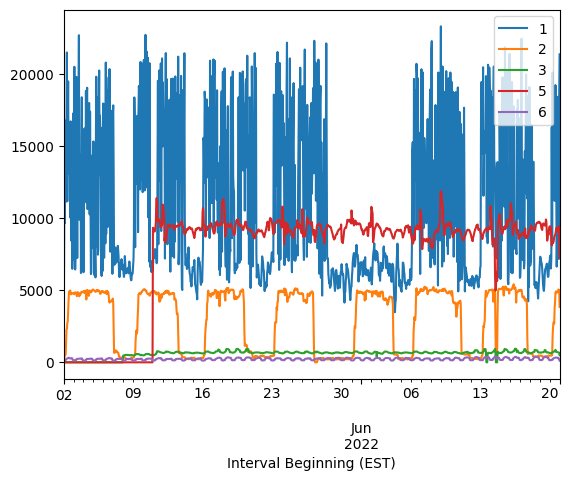

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
all_data = pd.DataFrame({str(i): get_site_data("files/site_" + str(i) + ".csv")['kWh'] for i in [1,2,3,5,6]})
plt.figure()
all_data.groupby(all_data.index.floor("h")).sum().plot()


* Site 1 is doing relatively numbers in terms of their performance. It must be some sort of industrial institution. The gap at the end of may/early june suggests that maybe it's a school (spring break), espeically given the sudden troughs on weekends.
* Site 2 seems to be the most consistent, with very clearly defined troughs over weekends. It also seems to have a limit of 5000. Seems it may be serve a small office with a strict power contract

In [21]:
site_2_hourly = all_data["2"].groupby(all_data.index.floor("h")).sum()
site_2_hourly[site_2_hourly > 5000].count() / site_2_hourly.count()
#Site 2, at an hourly basis, is only putting up 5000+ killowats 11% of the time

0.1125

Lets try again with just sites 3 and 6

<Axes: xlabel='Interval Beginning (EST)'>

<Figure size 640x480 with 0 Axes>

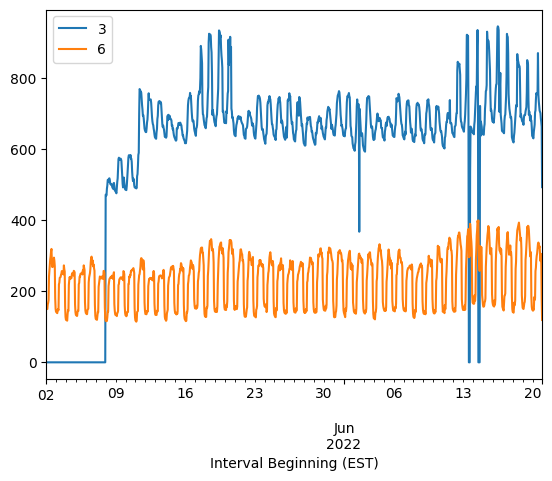

In [29]:
plt.figure()
all_data[["3","6"]].groupby(all_data.index.floor("h")).sum().plot()

- We see that Site 3 launched on 05/08
- Site 3 and 6 seem to be serving residential neighborhoods, with increased energy usage after 5/6 P.M (when people come home, and the lights/TV/electronics come on) and consistent daily oscillations
- Site 3 suffered the most from the event, with a similar drop on the following afternoon/evening
- **Both sites 3 and 6 have increased recorded consumption approaching the 14th. This nears the summer solstice, the longest, and sometimes hottest day of the year (06/21(?)). It's likely, given how hot and humid the midwest can get, that the increased AC usage on a wide scale induced the power outtage**

# Now lets see the event, +- 2 hours

<Axes: xlabel='Interval Beginning (EST)'>

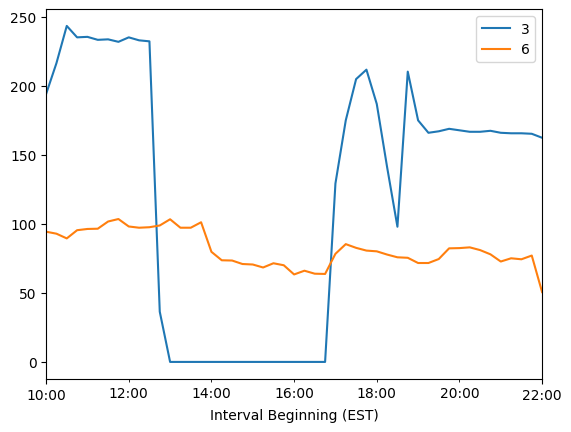

In [30]:
all_data[["3","6"]].loc[pd.Timestamp("2022-06-14 10:00:00"): pd.Timestamp("2022-06-14 22:00:00")].plot()

<Axes: xlabel='Interval Beginning (EST)'>

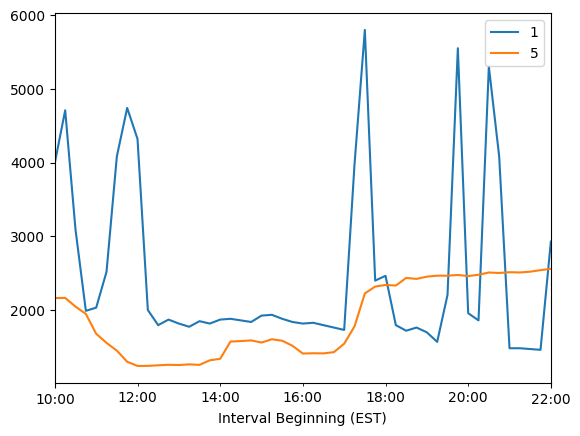

In [31]:

all_data[["1","5"]].loc[pd.Timestamp("2022-06-14 10:00:00"): pd.Timestamp("2022-06-14 22:00:00")].plot()

<Axes: xlabel='Interval Beginning (EST)'>

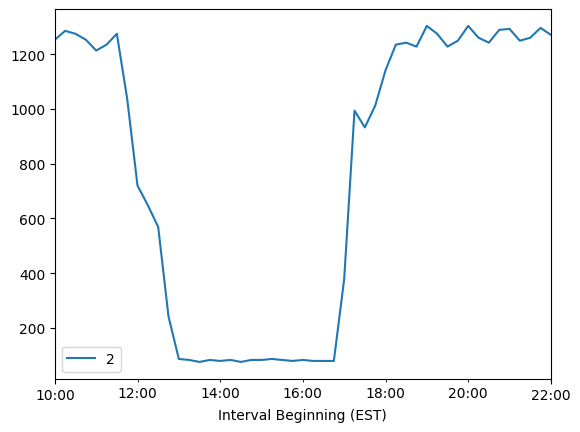

In [32]:
all_data[["2"]].loc[pd.Timestamp("2022-06-14 10:00:00"): pd.Timestamp("2022-06-14 22:00:00")].plot()

For step 3, we already have done the process of finding the performance relative to the baseline in step 1. We can recycle this process, and instead of taking the mean over the course of the event, we can apply the given profit share and rates to calculate payouts.

In [5]:
#3 payout calculation

hourly_rates = {
    pd.Timestamp("2022-06-14 14:00"): 1500,
    pd.Timestamp("2022-06-14 15:00"): 1800,
    pd.Timestamp("2022-06-14 16:00"): 3000,
    pd.Timestamp("2022-06-14 17:00"): 780,
}

def calculate_payouts(
    customer_series: pd.Series=get_site_data()["kWh"].loc[
                pd.Timestamp("2022-06-14 14:00:00") : pd.Timestamp(
                    "2022-06-14 17:00:00"
                )
            ],
    baseline: pd.Series=get_10of10_baselines(),
    customer_profit_share: float = 0.64,
    hourly_payout_rates: dict = hourly_rates,
):
    df = customer_series.groupby(customer_series.index.floor("h")).sum() # Aggregate by the hour

    df = pd.DataFrame((baseline - df), columns=["Performance"]) # Create an initial column of performance relative to the baseline (10of10 used for payout calculation)
    df["Revenue"] = (df["Performance"] * pd.Series(hourly_payout_rates) / 1000).apply(
        lambda x: max(x, 0)
    ) # Apply hourly rate payout for revenue.
    df["Customer Share"] = df["Revenue"] * customer_profit_share # Customer Share
    df["Voltus Share"] = df["Revenue"] - df["Customer Share"] # Voltus Share
    return df

calculate_payouts()
# calculate_payouts(data["kWh"].loc[
#                 pd.Timestamp("2022-06-14 14:00:00") : pd.Timestamp(
#                     "2022-06-14 17:00:00"
#                 )
#             ])

,Performance,Revenue,Customer Share,Voltus Share
2022-06-14 14:00:00,4478.76,6718.1400,4299.609600,2418.530400
2022-06-14 15:00:00,1632.96,2939.3280,1881.169920,1058.158080
2022-06-14 16:00:00,4445.28,13335.8400,8534.937600,4800.902400
2022-06-14 17:00:00,6876.36,5363.5608,3432.678912,1930.881888


*Something of note: If we were to always do this in succession of one another, assuming we've already calculated the 10of10 baseline average, we could just multiply that by however many hours the event was to calculate total performance*


In [6]:
# And now, we take the total
calculate_payouts().sum()

Performance       17433.360000
Revenue           28356.868800
Customer Share    18148.396032
Voltus Share      10208.472768
dtype: float64

**Why did we write these out as functions?**

1. We can re-use these functions for each site's data
2. Since no solution is implemented with 'magic numbers' (explicitly using the time frame we gave), we can utilize this for analysis on any future events that may happen, or general revenue calculation

In [7]:
from homework import construct_df, get_site_data

def main():
    df = construct_df()
    print(df)

    for i in [1, 2, 3, 5, 6]: # For each Site
        site_data = get_site_data("files/site_" + str(i) + ".csv")
        df.loc[i, "Average Performance (FSL)"] = customer_performance_from_baseline(
            site_data.loc[
                pd.Timestamp("2022-06-14 14:00:00") : pd.Timestamp(
                    "2022-06-14 17:00:00"
                )
            ]["kWh"],
            df.loc[i, "MISO FSL Baseline"] #Given Miso baseline (float),
        )

        df.loc[
            i, "Average Performance (10 of 10)"
        ] = customer_performance_from_baseline(
            site_data.loc[
                pd.Timestamp("2022-06-14 14:00:00") : pd.Timestamp(
                    "2022-06-14 17:00:00"
                )
            ]["kWh"],
            get_10of10_baselines(site_data["kWh"]) #Calculate 10of10 baseline (series),
        )

        payouts = calculate_payouts(
            site_data["kWh"].loc[
                pd.Timestamp("2022-06-14 14:00:00") : pd.Timestamp(
                    "2022-06-14 17:00:00"
                )
            ],
            get_10of10_baselines(site_data["kWh"]),
            df["Profit Share%"].loc[i],
        ).sum()
        df.loc[i, "Revenue"] = payouts["Revenue"]
        df.loc[i, "Customer Share"] = payouts["Customer Share"]
        df.loc[i, "Voltus Share"] = payouts["Voltus Share"]
    return df


print(main())


   MISO FSL Baseline  Profit Share% 10 of 10 baseline  \
1            10700.0           0.64                     
2             5400.0           0.62                     
3              850.0           0.56                     
5             9000.0           0.65                     
6              350.0           0.51                     

  Average Performance (10 of 10) Average Performance (FSL) Revenue  \
1                                                                    
2                                                                    
3                                                                    
5                                                                    
6                                                                    

  Customer Share Voltus Share  
1                              
2                              
3                              
5                              
6                              
   MISO FSL Baseline  Profit Share% 10 of 10